# Open Source Energy System Modeling 2022- HW3

## A) Add a new technology “gas power plant”

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Setting the modeling platform
mp = ixmp.Platform()

### A.1) Cloning the baseline scenario

In [3]:
model = "Westeros Electrified"

base = message_ix.Scenario(mp, model=model, scenario="baseline")
scenario = base.clone(
    model,
    "add_gas_ppl",
    "adding a gas power plant",
    keep_solution=False,
)
scenario.check_out()

In [4]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scenario.set("year")
country = "Westeros"

In [5]:
# Check the scenarios
mp.scenario_list()

,model,scenario,scheme,is_default,is_locked,cre_user,cre_date,upd_user,upd_date,lock_user,lock_date,annotation,version
0,Westeros Electrified,add_gas_ppl,MESSAGE,1,0,oezer,2022-06-12 16:01:42.485000,oezer,2022-06-12 16:01:44.382000,None,None,clone Scenario from 'Westeros Electrified|base...,57
1,Westeros Electrified,baseline,MESSAGE,1,0,oezer,2022-06-12 10:48:16.803000,oezer,2022-06-12 10:48:19.555000,None,None,basic model of Westeros electrification,1
2,Westeros Electrified,gas_ppl_emission_bound,MESSAGE,1,0,oezer,2022-06-12 16:01:46.229000,oezer,2022-06-12 16:01:47.239000,None,None,clone Scenario from 'Westeros Electrified|add_...,58
3,Westeros Electrified,gas_ppl_higher_emission,MESSAGE,1,0,oezer,2022-06-12 14:08:36.577000,oezer,2022-06-12 14:15:36.793000,None,None,clone Scenario from 'Westeros Electrified|add_...,1
4,Westeros Electrified,gas_ppl_lower_emission,MESSAGE,1,0,oezer,2022-06-12 14:21:54.909000,None,None,None,None,clone Scenario from 'Westeros Electrified|add_...,1
5,Westeros Electrified,gas_ppl_sweet_spot,MESSAGE,1,0,oezer,2022-06-12 14:31:48.039000,oezer,2022-06-12 14:56:28.425000,None,None,clone Scenario from 'Westeros Electrified|add_...,1


### A.2) Add gas power plant in addition to existing coal and wind power plants

In [6]:
scenario.add_set("technology", ["gas_ppl"])

In [7]:
# Some common values to be used for both the "input" and "output" parameters
base = dict(
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    time="year",
    unit="-",
)

# Create a base data frame for different "output" parameter values
base_output = make_df("output", **base, node_dest=country, time_dest="year")

#### I chose the **Combined-cycle + Post Combustion Capture Gas Power Plant** , and used the data from JRC-EU-TIMES model.[1]

In [8]:
# Add gas power plant output
gas_out = base_output.assign(
    technology="gas_ppl",
    commodity="electricity",
    level="secondary",
    value=1.0,
    unit="GWa",
)
scenario.add_par("output", gas_out)

### A.3) Add operational constraints and parameters for new gas power plant

In [9]:
# Add the capacity factor [1]

capacity_factor = {
    "gas_ppl": 1,
}

for tec, val in capacity_factor.items():
    df = make_df(
        "capacity_factor",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        time="year",
        unit="-",
        technology=tec,
        value=val,
    )
    scenario.add_par("capacity_factor", df)

In [10]:
# Add the technical life time [1]

lifetime = {
    "gas_ppl": 25,
}

for tec, val in lifetime.items():
    df = make_df(
        "technical_lifetime",
        node_loc=country,
        year_vtg=model_horizon,
        unit="y",
        technology=tec,
        value=val,
    )
    scenario.add_par("technical_lifetime", df)

### A.4) Add technological diffusion and contraction

In [11]:
# I kept the growth rate for gas power plant same as the existing power plants (10%) 

growth_technologies = [
    "coal_ppl",
    "wind_ppl",
    "gas_ppl"
]

for tec in growth_technologies:
    df = make_df(
        "growth_activity_up",
        node_loc=country,
        year_act=model_horizon,
        time="year",
        unit="-",
        technology=tec,
        value=0.1,
    )
    scenario.add_par("growth_activity_up", df)

### A.5) Defining the Energy Mix

In [12]:
# Same as the baseline

demand_per_year = 40 * 12 * 1000 / 8760

In [13]:
grid_efficiency = 0.9

In [14]:
historic_demand = 0.5 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.4
gas_fraction = 0.3
wind_fraction = 0.3

In [15]:
# Define the activity in the historic period.

old_activity = {
    "coal_ppl": coal_fraction * historic_generation,
    "wind_ppl": wind_fraction * historic_generation,
    "gas_ppl": gas_fraction * historic_generation,
}

history = [690]

for tec, val in old_activity.items():
    df = make_df(
        "historical_activity",
        node_loc=country,
        year_act=history,
        mode="standard",
        time="year",
        unit="GWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("historical_activity", df)

### A.6) Add specific investments costs (eur2010/kW) [1]

In [16]:
# Add a new unit for ixmp to recognize as valid
mp.add_unit("eur2010/kW")

# in eur2010/kW specific investment cost for year 2020
costs = {
    "gas_ppl": 1244,
}

for tec, val in costs.items():
    df = make_df(
        "inv_cost",
        node_loc=country,
        year_vtg=model_horizon,
        unit="eur2010/kW",
        technology=tec,
        value=val,
    )
    scenario.add_par("inv_cost", df)

### A.7) Add fixed O&M costs

In [17]:
# Add the fixed O&M costs in eur2010/kW

costs = {
    "gas_ppl": 44,
}

for tec, val in costs.items():
    df = make_df(
        "fix_cost",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        unit="eur2010/kW",
        technology=tec,
        value=val,
    )
    scenario.add_par("fix_cost", df)

### A.8) Add variable O&M costs [2]

In [18]:
mp.add_unit("eur/MWh")

costs = {
    "gas_ppl": 4,
}

for tec, val in costs.items():
    df = make_df(
        "var_cost",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        mode="standard",
        time="year",
        unit="eur/MWh",
        technology=tec,
        value=val,
    )
    scenario.add_par("var_cost", df)

### A.9) Solve the model

In [19]:
from message_ix import log

log.info(f"version number before commit(): {scenario.version}")

scenario.commit(comment="adding a gas power plant")

log.info(f"version number after commit(): {scenario.version}")

In [20]:
scenario.set_as_default()

In [21]:
scenario.solve()

In [22]:
scenario.var("OBJ")["lvl"]

176307.0625

### A.10) Plotting the results

In [23]:
from message_ix.reporting import Reporter

rep = Reporter.from_scenario(scenario)

from message_ix.util.tutorial import prepare_plots

prepare_plots(rep)

### Activity 

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

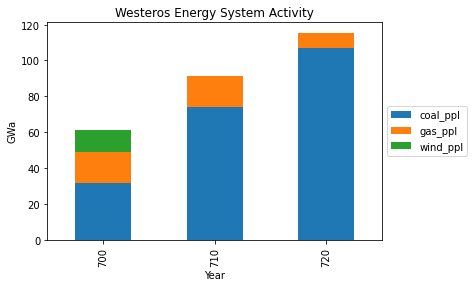

In [24]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "gas_ppl"])

# Trigger the calculation and plotting
rep.get("plot activity")

### Capacity

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

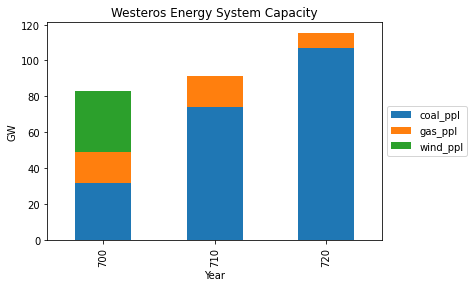

In [25]:
rep.get("plot capacity")

### New capacity

<AxesSubplot:title={'center':'Westeros Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

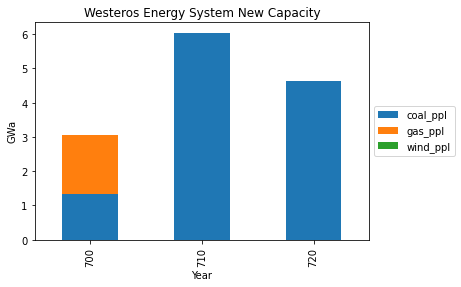

In [26]:
rep.get("plot new capacity")

## B) Adding emissions (from Westeros Tutorial - Introducing emissions part1/2)

In [27]:
model = "Westeros Electrified"

base = message_ix.Scenario(mp, model=model, scenario="add_gas_ppl")
scenario = base.clone(
    model,
    "gas_ppl_emission_bound",
    "adding emissions to add_gas_ppl",
    keep_solution=False,
)
scenario.check_out()

In [28]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scenario.set("year")
country = "Westeros"

In [29]:
# First we introduce the emission of CO2 and the emission category GHG
scenario.add_set("emission", "CO2")
scenario.add_cat("emission", "GHG", "CO2")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

# Last we add CO2 emissions to the coal powerplant
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="coal_ppl",
    emission="CO2",
    value=7.4,
)
scenario.add_par("emission_factor", emission_factor)

### B.1) Add emission factor for the gas power plant [1]

In [30]:
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="gas_ppl",
    emission="CO2",
    value=5.4, 
)
scenario.add_par("emission_factor", emission_factor)

### B.2) Define a bound on emissions

In [31]:
scenario.add_par(
    "bound_emission", [country, "GHG", "all", "cumulative"], value=500.0, unit="MtCO2"
)

### B.3) Solve the model

In [32]:
scenario.commit(comment="Adding emissions to add_gas_ppl scenario")
scenario.set_as_default()

In [33]:
scenario.solve()

In [34]:
scenario.var("OBJ")["lvl"]

191640.046875

### B.4) Check the emission levels and emission prices (from Westeros Tutorial - Introducing emissions part2/2)

In [35]:
scenario_bd = message_ix.Scenario(mp, model=model, scenario="gas_ppl_emission_bound")

In [36]:
# Emissions in MtCO2
emissions = scenario_bd.var("EMISS", {"node": "Westeros"})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,314.741386,0.0
1,Westeros,CO2,all,710,551.345511,0.0
2,Westeros,CO2,all,720,633.913103,0.0


In [37]:
# Price in USD/tCO2
emission_prices = scenario_bd.var("PRICE_EMISSION")
emission_prices

,node,type_emission,type_tec,year,lvl,mrg
0,Westeros,GHG,all,700,10.298336,0.0
1,Westeros,GHG,all,710,16.774903,0.0
2,Westeros,GHG,all,720,27.324550,0.0


### B.5) Plotting Results

In [38]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scenario_bd)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

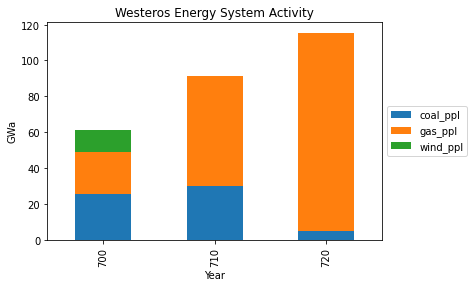

In [39]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "gas_ppl"])
rep.get("plot activity")

When we look at the system after introducing emission bound, it can be seen that the use of coal is significantly decreased. This can be explained by its high emission factor. Gas constitutes the majority of the energy mix of Westeros in 720. Since I introduced a combined cycle with a post-combustion capture gas power plant, I assumed the emission factor for this plant was lower than the standard combined cycle gas plants.

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

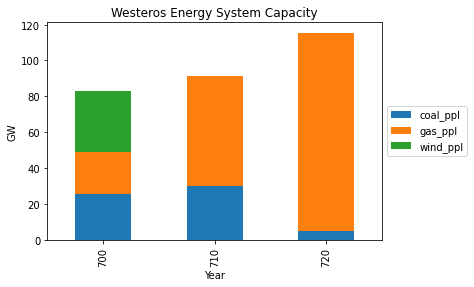

In [40]:
rep.get("plot capacity")

## C) Sensitivity Analysis with scenarios

### C.1) Higher Emission Prices

In this **Higher Emission Prices** scenario, reference emission prices are multipled with 3. I'm expecting to see the wind as major power generation resource with this approach.

In [41]:
higher_emission_prices = emission_prices.set_index("year").lvl*3
higher_emission_prices

year
700    30.895007
710    50.324710
720    81.973650
Name: lvl, dtype: float64

In [42]:
base = message_ix.Scenario(mp, model=model, scenario="add_gas_ppl")

scenario_higher = base.clone(
    model,
    "gas_ppl_higher_emission", 
    "adding higher carbon price", 
    keep_solution=False,
)
scenario_higher.check_out()

In [43]:
scenario_higher.add_set("emission", "CO2")
scenario_higher.add_cat("emission", "GHG", "CO2")
scenario_higher.add_par("emission_factor", scenario_bd.par("emission_factor"))

In [44]:
scenario_higher.add_set("type_year", [700, 710, 720])

# In case you need to add the new unit to the platform
mp.add_unit("USD/tCO2")

tax_emission = make_df(
    "tax_emission",
    node="Westeros",
    type_year=[700, 710, 720],
    type_tec="all",
    unit="USD/tCO2",
    type_emission="GHG",
    value=higher_emission_prices,
)
scenario_higher.add_par("tax_emission", tax_emission)
scenario_higher.par("tax_emission")

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,30.895007,USD/tCO2
1,Westeros,GHG,all,710,50.324710,USD/tCO2
2,Westeros,GHG,all,720,81.973650,USD/tCO2


In [45]:
scenario_higher.commit(comment="setting higher taxes on emissions")

In [46]:
scenario_higher.solve()

In [47]:
scenario_higher.var("EMISS", {"node": "Westeros"})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,229.563052,0.0
1,Westeros,CO2,all,710,160.232879,0.0
2,Westeros,CO2,all,720,0.000000,0.0


### Results of Higher Emission Prices scenario

In [48]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scenario_higher)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

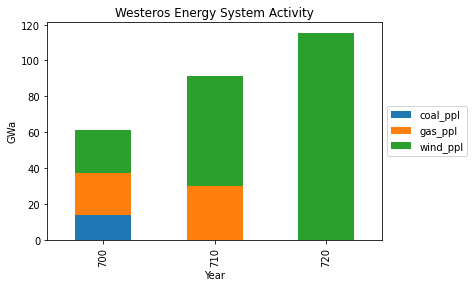

In [49]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "gas_ppl"])
rep.get("plot activity")

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

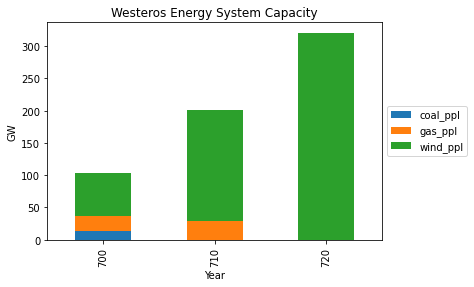

In [50]:
rep.get("plot capacity")

As I expected at the beginning, coal and gas phased out until 720.

### C.2) Lower Emission Prices

In this **Lower Emission Prices** scenario, reference emission prices are divided by 3. I'm expecting to see the coal as the major power generation resource with this approach.

In [51]:
lower_emission_prices = emission_prices.set_index("year").lvl/3
lower_emission_prices

year
700    3.432779
710    5.591634
720    9.108183
Name: lvl, dtype: float64

In [52]:
base = message_ix.Scenario(mp, model=model, scenario="add_gas_ppl")

scenario_lower = base.clone(
    model,
    "gas_ppl_lower_emission", 
    "adding lower carbon price", 
    keep_solution=False,
)
scenario_lower.check_out()

In [53]:
scenario_lower.add_set("emission", "CO2")
scenario_lower.add_cat("emission", "GHG", "CO2")
scenario_lower.add_par("emission_factor", scenario_bd.par("emission_factor"))

In [54]:
scenario_lower.add_set("type_year", [700, 710, 720])

# In case you need to add the new unit to the platform
mp.add_unit("USD/tCO2")

tax_emission = make_df(
    "tax_emission",
    node="Westeros",
    type_year=[700, 710, 720],
    type_tec="all",
    unit="USD/tCO2",
    type_emission="GHG",
    value=lower_emission_prices,
)
scenario_lower.add_par("tax_emission", tax_emission)
scenario_lower.par("tax_emission")

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,3.432779,USD/tCO2
1,Westeros,GHG,all,710,5.591634,USD/tCO2
2,Westeros,GHG,all,720,9.108183,USD/tCO2


In [55]:
scenario_lower.commit(comment="setting lower taxes on emissions")

In [56]:
scenario_lower.solve()

In [57]:
scenario_lower.var("EMISS", {"node": "Westeros"})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,327.412297,0.0
1,Westeros,CO2,all,710,639.518842,0.0
2,Westeros,CO2,all,720,837.759421,0.0


### Results of Lower Emission Prices scenario

In [58]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scenario_lower)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

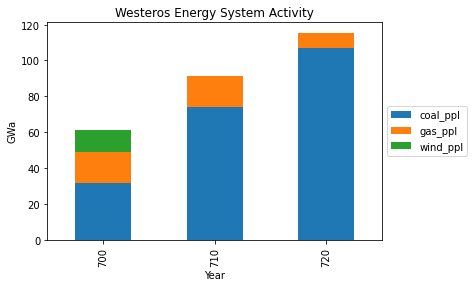

In [59]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "gas_ppl"])
rep.get("plot activity")

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

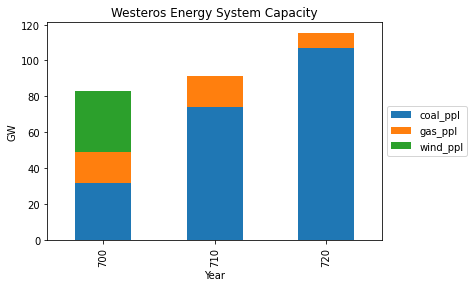

In [60]:
rep.get("plot capacity")

As I expected at the beginning, coal constitues the majority of electricity generation with gas in 720 with this lower emission prices scenario.

### C.3) Sweet-spot

In this **Sweet-spot** scenario, I'll try to find a set of emission prices where all three power plants will be used to generate power in 720.

In [61]:
base = message_ix.Scenario(mp, model=model, scenario="add_gas_ppl")

scenario_sweet_spot = base.clone(
    model,
    "gas_ppl_sweet_spot", 
    "finding sweet spot on carbon prices", 
    keep_solution=False,
)
scenario_sweet_spot.check_out()

In [62]:
scenario_sweet_spot.add_set("emission", "CO2")
scenario_sweet_spot.add_cat("emission", "GHG", "CO2")
scenario_sweet_spot.add_par("emission_factor", scenario_bd.par("emission_factor"))

In [63]:
scenario_sweet_spot.add_set("type_year", [700, 710, 720])

# In case you need to add the new unit to the platform
mp.add_unit("USD/tCO2")


tax_emission = make_df(
    "tax_emission",
    node="Westeros",
    type_year=[700, 710, 720],
    type_tec="all",
    unit="USD/tCO2",
    type_emission="GHG",
    value=[5, 25, 30]
)


scenario_sweet_spot.add_par("tax_emission", tax_emission)
scenario_sweet_spot.par("tax_emission")

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,5.0,USD/tCO2
1,Westeros,GHG,all,710,25.0,USD/tCO2
2,Westeros,GHG,all,720,30.0,USD/tCO2


In [64]:
scenario_sweet_spot.commit(comment="find a sweet-spot on carbon prices")

In [65]:
scenario_sweet_spot.solve()

In [66]:
scenario_sweet_spot.var("EMISS", {"node": "Westeros"})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,314.741386,0.0
1,Westeros,CO2,all,710,383.438102,0.0
2,Westeros,CO2,all,720,501.472972,0.0


### Results of Sweet-spot scenario

In [67]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scenario_sweet_spot)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

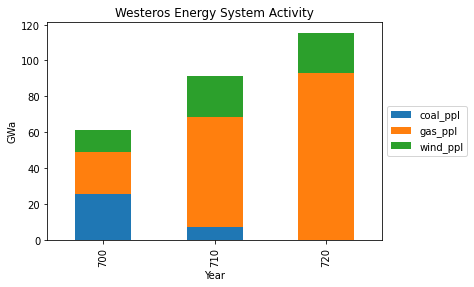

In [68]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "gas_ppl"])
rep.get("plot activity")

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

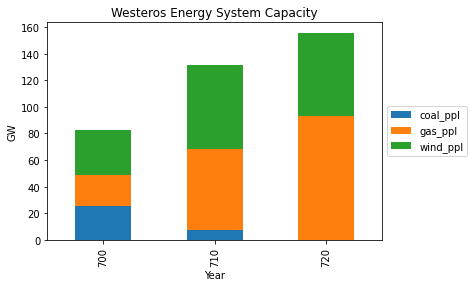

In [69]:
rep.get("plot capacity")

I found a sweet-for carbon price in years 700 and 710. However, in year 720 I couldn't find a carbon price where all three resources are used in the same time.

## References

[1] Simoes, S., Nijs, W., Ruiz, P., Sgobbi, A., Radu, D., Bolat, P., Thiel, C. and Peteves, S., 2013. The JRC-EU-TIMES model: Assessing the long-term role of the SET Plan Energy technologies. [online] Available at: <https://energy.ec.europa.eu/topics/research-and-technology/strategic-energy-technology-plan_en> [Accessed 10 June 2022].

[2] Zero emissions platform. n.d. The Costs of CO2 Capture: Post-demonstration CCS in the EU. [online] Available at: <http://www.graz-cycle.tugraz.at/pdfs/CO2-Capture-Report.pdf> [Accessed 12 June 2022].

[3] Daniel Huppmann, Matthew Gidden, Oliver Fricko, Peter Kolp, Clara Orthofer, Michael Pimmer, Nikolay Kushin, Adriano Vinca, Alessio Mastrucci, Keywan Riahi, and Volker Krey. The MESSAGEix Integrated Assessment Model and the ix modeling platform (ixmp): An open framework for integrated and cross-cutting analysis of energy, climate, the environment, and sustainable development. Environmental Modelling & Software, 112:143–156, 2019. doi:10.1016/j.envsoft.2018.11.012.